# Image Regression - Find Center of Head

Here we are trying to do an image regression with deep learning.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Exploring Data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE); path

PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose')

In [4]:
path.ls()[:10]

[PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/io_sample.cpp'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/24'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/09'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/17'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/readme.txt'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/12.obj'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/15'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/19'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/12'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/13')]

In [5]:
!ls {path/'24'} | head

depth.cal
frame_00000_pose.txt
frame_00000_rgb.jpg
frame_00001_pose.txt
frame_00001_rgb.jpg
frame_00002_pose.txt
frame_00002_rgb.jpg
frame_00003_pose.txt
frame_00003_rgb.jpg
frame_00004_pose.txt
ls: write error: Broken pipe


In [6]:
!cat {path/'readme.txt'}

Biwi Kinect Head Pose Database

This database is made available for non-commercial use such as university research and education.

We kindly ask you to cite the following reference in your publications related to this work:

@article{fanelli_IJCV,
  author = {Fanelli, Gabriele and Dantone, Matthias and Gall, Juergen and Fossati, Andrea and Van Gool, Luc},
  title = {Random Forests for Real Time 3D Face Analysis},
  journal = {Int. J. Comput. Vision},
  year = {2013},
  month = {February},
  volume = {101},
  number = {3},
  pages = {437--458}
}

The database contains 24 sequences acquired with a Kinect sensor. 20 people (some were recorded twice - 6 women and 14 men) were recorded while turning their heads, sitting in front of the sensor, at roughly one meter of distance.

For each sequence, the corresponding .obj file represents a head template deformed to match the neutral face of that specific person.
In each folder, two .cal files contain calibration information for the depth and t

In [7]:
!cat {path/'24/rgb.cal'}

505.265 0 320 
0 505.265 240.5 
0 0 1 

0 0 0 0 

0.999984 -3.3597e-05 -0.00570878 
0.000178345 0.999678 0.0253567 
0.0057061 -0.0253573 0.999662 

-29.8935 6.41509 -15.3104 

640 480


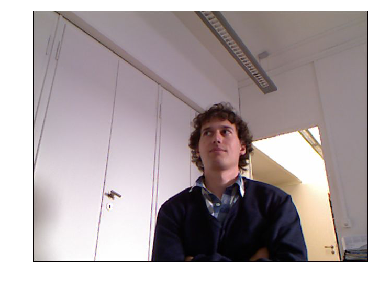

In [8]:
open_image(path/'24/frame_00000_rgb.jpg').show(figsize=(6,6))

In [9]:
!cat {path/'24/frame_00000_pose.txt'}

0.984735 0.00470425 0.173994 
-0.0615351 0.944489 0.322728 
-0.162817 -0.328508 0.930362 

98.2758 0.641932 933.201 



## Information About the Dataset

In this dataset images are group into directories. In that directory there's an special file called `depth.cal` which has some camera caliberation details as a matrix.

Then for each and every head shot, there's a `.jpg` file and `.txt` file containing a metrix. 

And it doesn't show anything about the center of the face direcly. <br/>
They asked us to use the `.txt` and the `rgb.cal` metrices to find out the center of the page. <br/>
The algorithm to do that also given.

In [10]:
sample_image_path = path/'24'/'frame_00235_rgb.jpg'; sample_image_path

PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/24/frame_00235_rgb.jpg')

In [11]:
image_to_pose_path = lambda x: f'{x}'.replace('_rgb.jpg', '_pose.txt')

In [12]:
sample_pose_path = image_to_pose_path(sample_image_path); sample_pose_path

'/home/arunoda_susiripala/.fastai/data/biwi_head_pose/24/frame_00235_pose.txt'

In [13]:
!cat {sample_pose_path}

0.997132 0.0415027 0.0632912 
-0.0597686 0.944827 0.322072 
-0.0464323 -0.324931 0.944597 

116.001 0.313534 943.68 



In [14]:
image_to_cal_path = lambda x: path/x.parent.stem/'rgb.cal'

In [15]:
sample_cal_path = image_to_cal_path(sample_image_path); sample_cal_path

PosixPath('/home/arunoda_susiripala/.fastai/data/biwi_head_pose/24/rgb.cal')

In [16]:
!cat {sample_cal_path}

505.265 0 320 
0 505.265 240.5 
0 0 1 

0 0 0 0 

0.999984 -3.3597e-05 -0.00570878 
0.000178345 0.999678 0.0253567 
0.0057061 -0.0253573 0.999662 

-29.8935 6.41509 -15.3104 

640 480


In [17]:
# When loading the cal, we only need the matrix listen in the first 3 lines
sample_cal = np.genfromtxt(sample_cal_path, skip_footer=6); sample_cal

array([[505.265,   0.   , 320.   ],
       [  0.   , 505.265, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [18]:
# For the post, we only need the last line
sample_pose = np.genfromtxt(sample_pose_path, skip_header=3); sample_pose

array([1.16001e+02, 3.13534e-01, 9.43680e+02])

In [19]:
def get_center(image_path):
    cal = np.genfromtxt(image_to_cal_path(image_path), skip_footer=6)
    coords = np.genfromtxt(image_to_pose_path(image_path), skip_header=3)
    
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

In [20]:
get_center(sample_image_path)

tensor([240.6679, 382.1092])

In [21]:
def show_head_center(image_path):
    img = open_image(image_path)
    center = get_center(image_path)
    center_point = ImagePoints(FlowField(img.size, center), scale=True)
    img.show(y=center_point, figsize=(6, 6))

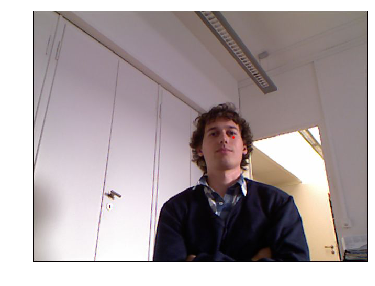

In [22]:
show_head_center(sample_image_path)